In [1]:
import math
import numpy as np
from torch import cos, sin
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *

from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import sample_farthest_points
from descartes import PolygonPatch
from pytorch3d.io import IO, load_obj, save_obj,load_objs_as_meshes
from pytorch3d.structures import join_meshes_as_batch, Meshes, Pointclouds

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from alpha_shapes import Alpha_Shaper, plot_alpha_shape
from torch import Tensor, tensor

import shapely
import os
import trimesh
import plotly.graph_objects as go

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
torch.autograd.set_detect_anomaly(True)

def least_squares(u0, tgt_vtxs):
    """
    u0 are vertices
    """
    if not torch.is_tensor(u0):
        u0 = torch.tensor(u0)
    if not torch.is_tensor(tgt_vtxs):
        tgt_vtxs = torch.tensor(tgt_vtxs)
    res = torch.square(u0 - tgt_vtxs.flatten()).sum()
    return res.double()

def least_squares_grad(u0, tgt_vtxs):
    if torch.is_tensor(u0):
        u0 = u0.detach().clone()
    else:
        u0 = torch.tensor(u0)
    if torch.is_tensor(tgt_vtxs):
        tgt_vtxs = tgt_vtxs.detach().clone()
    else:
        tgt_vtxs = torch.tensor(tgt_vtxs)
        
    # Ensure that u0 requires gradients
    gradient = 2 * (u0 - tgt_vtxs.flatten())
    return gradient.double()


def calculate_volume(vertices, faces):
    face_vertices = vertices[faces]  # (F, 3, 3)
    v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
    
    # Compute determinant of the 3x3 matrix [v0, v1, v2]
    face_volumes = torch.det(torch.stack([v0, v1, v2], dim=-1)) / 6.0  # Shape: (F,)
    volume = face_volumes.sum()
    return volume.abs()


def volume_constraint(x, faces, tgt_vol):
    """
    Calculate the volume of a mesh using PyTorch tensors.
    Args:
        vertices_torch: Nx3 tensor of vertex coordinates
        faces: Mx3 array of face indices
    Returns:
        volume: Total volume of the mesh as a PyTorch scalar
    """
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces)
    if not torch.is_tensor(tgt_vol):
        tgt_vol = torch.tensor(tgt_vol)

    vertices = x.view(-1,3)
    faces = faces.view(-1,3).int()
    volume = calculate_volume(vertices, faces)
    res = volume.abs() - tgt_vol
    return res.double()

def volume_constraint_grad(x, faces):
    if torch.is_tensor(x):
        x = x.detach().clone()
    else:
        x = torch.tensor(x)
    if torch.is_tensor(faces):
        faces = faces.detach().clone()
    else:
        faces = torch.tensor(faces)
    faces = faces.to(dtype=torch.int64)

    vertices_torch = x.view(-1, 3)
    p0 = vertices_torch[faces[:, 0]]  # (F, 3)
    p1 = vertices_torch[faces[:, 1]]  # (F, 3)
    p2 = vertices_torch[faces[:, 2]]  # (F, 3)

    grad_p0 = torch.cross(p1, p2, dim=1) / 6.0
    grad_p1 = torch.cross(p2, p0, dim=1) / 6.0
    grad_p2 = torch.cross(p0, p1, dim=1) / 6.0

    grad_verts = torch.zeros_like(vertices_torch)
    grad_verts.scatter_add_(0, faces[:, 0].unsqueeze(1).expand(-1, 3), grad_p0)
    grad_verts.scatter_add_(0, faces[:, 1].unsqueeze(1).expand(-1, 3), grad_p1)
    grad_verts.scatter_add_(0, faces[:, 2].unsqueeze(1).expand(-1, 3), grad_p2)

    analytical_grad = grad_verts.flatten()
    return analytical_grad 

def padded_to_packed(xs, lengths):
    packed = []
    batch_size = xs.size(0)
    for b in range(batch_size):
        n = lengths[b]
        packed.append(xs[b][:n])
    packed = torch.cat(packed, dim=0)
    return packed

y* = argmin ||X - tgt||^2

target depends on input X

We have mesh points in 3D <-- X
2D edge maps <-- upper level targets

lower level: find Y closest to X that satisfy volume constraint, so Y is being optimised in the lower point

argmin ||X - Y||^2 s.t. vol(Y) = constant

In [4]:
class ConstrainedProjectionNode(EqConstDeclarativeNode):
    """
    Performs a projection of the input points X onto the nearest points Y such that the volume of Y is constant.
    """
    def __init__(self, src: Meshes, tgt: Meshes):
        super().__init__(eps=1.0e-6) # relax tolerance on optimality test 
        self.src = src # source meshes (B,)
        # self.tgt = tgt # target meshes (B,)
        self.b = len(src)

    def objective(self, xs: torch.Tensor, y: torch.Tensor, scatter_add=False):
        """
        Calculates sum of squared differences between source and target meshes.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices        
        """
        src_verts = padded_to_packed(xs, self.src.num_verts_per_mesh()).view(-1,3)
        tgt_verts = padded_to_packed(y, self.src.num_verts_per_mesh()).view(-1,3)

        sqr_diffs = torch.square(src_verts - tgt_verts).sum(dim=-1) # (sum(V_i))
        n_batches = len(self.src)
        sse = torch.zeros(n_batches, dtype=sqr_diffs.dtype)
        if scatter_add:
            sse.scatter_add_(0, self.src.verts_packed_to_mesh_idx(), sqr_diffs)
        else:
            n_verts_per_mesh = self.src.num_verts_per_mesh()
            for i in range(n_batches):
                mesh_to_vert = self.src.mesh_to_verts_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_vert[i]
                end = start + n_verts_per_mesh[i]
                sse[i] = sqr_diffs[start:end].sum()  # Sum over all faces
        return sse

    def equality_constraints(self, xs, y, scatter_add=False):
        """
        Enforces volume constraint of projected points
        Assumes same number of vertices in each projected mesh currently

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        y_packed = padded_to_packed(y, self.src.num_verts_per_mesh())
        verts_packed = y_packed.view(-1,3) # (sum(V_i), 3)

        faces_packed = self.src.faces_packed()  # (sum(F_i), 3)
        face_vertices = verts_packed[faces_packed]  # (sum(F_i), 3, 3)
        
        # Calculate tetrahedron volumes for each face
        v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
        cross_product = torch.cross(v0, v1, dim=-1)  # (F, 3)
        face_volumes = torch.sum(cross_product * v2, dim=-1) / 6.0  # (F,)
        volumes = torch.zeros(n_batches, device=verts_packed.device, dtype=face_volumes.dtype)
        if scatter_add:
            volumes.scatter_add_(0, self.src.faces_packed_to_mesh_idx(), face_volumes)
        else:
            n_faces_per_mesh = self.src.num_faces_per_mesh()
            for i in range(n_batches):
                mesh_to_face = self.src.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_face[i]
                end = start + n_faces_per_mesh[i]
                volumes[i] = face_volumes[start:end].sum()  # Sum over all faces

        volumes = volumes.abs()
        return volumes  # Shape: (B,)    
    
    def solve(self, xs: torch.Tensor):
        """Projects the vertices onto the target mesh vertices across batches.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of vertices in the batched meshes

        Returns:
            results (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        results = torch.zeros((n_batches, num_verts_per_mesh.max(), 3), dtype=torch.double)
        for batch in range(n_batches):
            n_verts = num_verts_per_mesh[batch]
            verts = xs[batch][:n_verts].flatten().detach().double().cpu().numpy()
            faces = self.src[batch].faces_packed().detach().int().cpu().numpy()
            
            # Y = xs[batch][:n_verts].flatten().detach().double().cpu() * 2
            # Y = Y.numpy()
            Y = xs[batch][:n_verts].flatten().detach().double().cpu().numpy() 

            with torch.no_grad():
                src_vtx = self.src[batch].verts_packed().detach()
                src_faces = self.src[batch].faces_packed().detach()
                vol = calculate_volume(src_vtx, src_faces)

            eq_constraint = {
                'type': 'eq',
                'fun' : lambda u: volume_constraint(u, faces, vol).cpu().numpy(),
                'jac' : lambda u: volume_constraint_grad(u, faces).cpu().numpy(),
            }

            res = opt.minimize(
                lambda u: least_squares(u, verts).detach().cpu().numpy(),
                Y,
                method='SLSQP',
                jac=lambda u: least_squares_grad(u, verts).cpu().numpy(),
                constraints=[eq_constraint],
                options={'ftol': 1e-4, 'iprint': 2, 'maxiter': 100}
            )

            if not res.success:
                print("FAILED:", res.message)
            results[batch] = torch.tensor(res.x, dtype=torch.double, requires_grad=True).view(-1,3)
        results = torch.nn.utils.rnn.pad_sequence(results, batch_first=True)
        return results,None
    

class ConstrainedProjectionFunction(DeclarativeFunction):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


Pseudo code:
- load in the meshes
- inner problem needs access to the vertices, number of meshes, faces, and indexing
- outer problem needs access to projected vertices, number of meshes, and indexing. Also needs projection matrices, and edge maps of renders, so perform edge detection of renders beforehand.

just provide both with the meshes lol

Projection:
Get the indexing correct for the vertices, take the projection of these vertices

In [5]:
# outer problem

def create_padded_tensor(vertices, vert2mesh, max_V, B):
    padded = torch.zeros((B, max_V, 3),device=vertices.device)
    for i in range(B):
        mesh_vertices = vertices[vert2mesh == i]
        num_vertices = mesh_vertices.shape[0]
        padded[i, :num_vertices, :] = mesh_vertices
    return padded

from shapely.ops      import unary_union
from shapely.geometry import Polygon
import numpy as np

def get_boundary(projverts: torch.Tensor, faces: torch.Tensor, fnorms: torch.Tensor, P: torch.Tensor, eps=1e-1):
    """
    Args:
        projverts: (V, 2) projected 2D points
        faces: (F, 3) long tensor of face indices
        fnorms: (F, 3) face normals (in world coordinates)
        P: (3, 4) projection matrix
    Returns:
        (L_total, 2) tensor of boundary points (torch, differentiable)
    """
    # 1) Compute visibility mask (front-facing)
    R = P[:, :3]  # (3, 3)
    dot_z = (fnorms.double() @ R.T)[:, 2]
    visible = dot_z > 0
    vis_idx = torch.nonzero(visible).squeeze(-1)
    
    # 2) Project each visible triangle as a Polygon
    V2 = projverts.detach().cpu().numpy()
    F_np = faces[vis_idx].cpu().numpy()
    tris = [Polygon(V2[f]) for f in F_np]
    unioned = unary_union(tris).buffer(eps).buffer(-eps)

    # 3) Extract exterior + interior rings
    rings = []
    if unioned.geom_type == 'Polygon':
        rings.append(np.array(unioned.exterior.coords))
        for interior in unioned.interiors:
            rings.append(np.array(interior.coords))

    elif unioned.geom_type == 'MultiPolygon':
        print("unioned.geom_type == 'MultiPolygon'")
        unioned = max(unioned.geoms, key=lambda p: p.area)

        rings.append(np.array(unioned.exterior.coords))
    else:
        raise ValueError(f"Unexpected geometry type: {unioned.geom_type}")

    # rings = [np.array(unioned.exterior.coords)]
    # for interior in unioned.interiors:
    #     rings.append(np.array(interior.coords))

    # 4) Snap rings to closest projected vertices
    loops = []
    for ring in rings:
        coords_t = torch.from_numpy(ring).to(projverts)           # (L, 2)
        diffs = coords_t[:, None, :] - projverts[None, :, :]      # (L, V, 2)
        d2 = (diffs ** 2).sum(dim=2)                              # (L, V)
        idx = torch.argmin(d2, dim=1)
        idx_u = torch.unique_consecutive(idx)
        if idx_u.numel() > 1 and idx_u[0] == idx_u[-1]:
            idx_u = idx_u[:-1]
        loops.append(projverts[idx_u])

    return torch.cat(loops, dim=0)

class PyTorchChamferLoss(nn.Module):
    def __init__(self, src: Meshes, tgt: Meshes, projmatrices, edgemap_info):
        super().__init__()
        self.src = src  # (B meshes)
        self.tgt = tgt  # (B meshes)
        self.projmatrices = projmatrices # (P, 3, 4)
        self.edgemaps = edgemap_info[0] # (P, max_Ni, 2)
        self.edgemaps_len = edgemap_info[1] # (P,)
    
    def project_vertices(self, vertices):
        """
        Projects a set of vertices into multiple views using different projection matrices.
        Args:
            vertices: Tensor of shape (N, 3), representing 3D vertex positions.
        Returns:
            Tensor of shape (P, N, 2), containing projected 2D points in each view.
        """
        V = vertices.shape[0]
        projection_matrices = self.projmatrices

        ones = torch.ones((V, 1), dtype=vertices.dtype, device=vertices.device)
        vertices_homogeneous = torch.cat([vertices, ones], dim=1).double()  # Shape: (V, 4)

        # Perform batched matrix multiplication (P, 3, 4) @ (V, 4, 1) -> (P, V, 3)
        projected = torch.einsum("pij,vj->pvi", projection_matrices, vertices_homogeneous)  # (P, V, 3)
        
        projected_cartesian = projected[:, :, :2] / projected[:, :, 2:3]  # (P, V, 2)

        return projected_cartesian

        
    def forward(self, y):
        B, P = len(self.src), self.projmatrices.size(0)
        vertices = y
        # project vertices
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        projected_vertices = [] # (B, P, V, 2)
        for b in range(B):
            end = num_verts_per_mesh[b]
            projverts = self.project_vertices(vertices[b][:end,:])  # Shape: (P, V, 2)
            projected_vertices.append(projverts)  # Store without padding

        # get boundaries
        faces_padded = self.src.faces_padded()              # (B, F_max, 3)
        deformed_meshes = self.src.update_padded(y)
        fnorms_padded = deformed_meshes.faces_normals_padded()  # (B, F_max, 3)

        boundaries = [] 
        boundary_lengths = torch.zeros(B, P)
        num_faces = self.src.num_faces_per_mesh()  # list of length B
        for b, batch in enumerate(projected_vertices):
            boundaries_b = []
            faces_b = faces_padded[b][:num_faces[b]]
            fnorms_b = fnorms_padded[b][:num_faces[b]]

            for p, projverts in enumerate(batch):
                boundary = get_boundary(projverts, faces_b, fnorms_b, self.projmatrices[p])
                boundaries_b.append(boundary)
                boundary_lengths[b,p] = len(boundary)
            padded_boundaries = torch.nn.utils.rnn.pad_sequence(boundaries_b, batch_first=True, padding_value=0.0)
            boundaries.append(padded_boundaries)

        # perform chamfer
        chamfer_loss = torch.zeros(B)
        for b in range(B):
            boundaries_b = boundaries[b].float()
            edgemaps_b = self.edgemaps[b].float()
            res, _ = chamfer_distance(  x=boundaries_b,
                                        y=edgemaps_b,
                                        x_lengths=boundary_lengths[b].long(),
                                        y_lengths=self.edgemaps_len[b].long(),
                                        batch_reduction="mean",
                                        point_reduction="mean")
            chamfer_loss[b] = res.sum()
        return chamfer_loss.double() * 10



In [6]:
def chamfer_gt(mesh, src:Meshes, tgt:Meshes):
    res,_ = chamfer_distance(x=mesh.detach().float(), 
                             y=tgt.verts_padded().float().detach(),
                             x_lengths=src.num_verts_per_mesh(),
                             y_lengths=tgt.num_verts_per_mesh(),
                             batch_reduction=None,
                             point_reduction="mean")
    # print("Chamfer", res.size())
    return res.tolist() # (B,)


def sse_gt(mesh, src:Meshes, tgt:Meshes):
    sqr_diff = torch.square(mesh - tgt.verts_padded().detach())
    sse = sqr_diff.sum(dim=(1, 2))
    # print("sqrdiff", sqr_diff.size(),"sse", sse.size(), "tgt", tgt.verts_padded().size())
    return sse.tolist() # (B,)


def iou_gt(mesh, src:Meshes, tgt:Meshes,engine='manifold'):
    batch_size = len(mesh)
    ious = []
    gt = tgt.verts_padded()
    for b in range(batch_size):
        num_verts_src = src.num_verts_per_mesh()[b].item()
        num_verts_tgt = tgt.num_verts_per_mesh()[b].item()
        
        mesh_trimesh = trimesh.Trimesh(vertices=mesh[b][:num_verts_src].detach().cpu().numpy(), 
                                       faces=src[b].faces_packed().detach().cpu().numpy())
        gt_trimesh = trimesh.Trimesh(vertices=gt[b][:num_verts_tgt].detach().cpu().numpy(), 
                                     faces=tgt[b].faces_packed().detach().cpu().numpy())
        intersection = mesh_trimesh.intersection(other=gt_trimesh, engine=engine)
        union = mesh_trimesh.union(other=gt_trimesh, engine=engine)
        
        if union.volume == 0:  # Handle edge case
            iou = 0.0
        else:
            iou = intersection.volume / union.volume
        ious.append(iou)
    return ious # (B,)

In [7]:
def plot_projections(mesh, projverts, projmats, edgemaps):
    plt.ioff()  # Disable interactive mode

    P, _, _ = projmats.shape
    edge_coords, edge_lens = edgemaps
    fig, axes = plt.subplots(1, P, figsize=(2 * P, 2))  # Increase figure size
    if P == 1:
        axes = [axes]  # Ensure iterable for a single subplot case
    faces = mesh.faces_packed()                     # (F, 3)
    mesh.update_padded(projverts.unsqueeze(0))
    fnorms = mesh.faces_normals_packed()            # (F, 3)

    for i in range(P):
        proj_2d_hom = (projmats[i] @ torch.cat([projverts, torch.ones(projverts.shape[0], 1)], dim=1).T).T
        proj_2d = proj_2d_hom[:, :2] / proj_2d_hom[:, 2:3]  # Normalize by depth

        boundary_pts = get_boundary(proj_2d, faces, fnorms, projmats[i])

        valid_edges = edge_coords[i, :edge_lens[i]]

        ax = axes[i]
        ax.scatter(proj_2d[:, 0], proj_2d[:, 1], c='b', s=8, label="Projected Vertices")
        ax.scatter(valid_edges[:, 0], valid_edges[:, 1], c='r', s=1, label="Edge Coordinates")
        ax.scatter(boundary_pts[:, 0], boundary_pts[:, 1], c='g', s=3, label="Boundary Points")

        ax.set_title(f"Projection {i+1}", fontsize=10)  # Reduce title size
        ax.set_xlabel("x", fontsize=8)
        ax.set_ylabel("y", fontsize=8)
        
        ax.tick_params(axis='both', which='major', labelsize=6)  # Reduce tick label size
        ax.axis("equal")
        ax.invert_yaxis()

    plt.tight_layout(pad=0.5)  # Reduce whitespace
    plt.subplots_adjust(wspace=0.1)  # Reduce horizontal space
    plt.show()
    plt.close(fig)


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def outer_problem(src: Meshes, tgt: Meshes, projmats, edgemap_info, n_iters, lr, moment, verbose=True):
    node = ConstrainedProjectionNode(src, tgt)
    verts_init = src.verts_padded() # (B, max Vi, 3)
    verts_init.requires_grad = True
    projverts_init = node.solve(verts_init)
    # apply solve
    projverts_init = ConstrainedProjectionFunction.apply(node, verts_init) # (B, max Vi, 3)

    chamfer_loss = PyTorchChamferLoss(src, tgt, projmats, edgemap_info)

    history = [projverts_init]
    verts = verts_init.clone().detach().requires_grad_(True)

    optimiser = torch.optim.SGD([verts], lr=lr, momentum=moment)
    a,b = edgemap_info
    a,b = a[0], b[0]
    
    plot_projections(src, verts.detach().squeeze().double(), projmats, (a,b))

    min_loss = float("inf")
    best_verts = None
    # verts_prev = None
    for i in range(n_iters):
        optimiser.zero_grad(set_to_none=True)
        projverts = ConstrainedProjectionFunction.apply(node, verts)
        history.append(projverts.detach().clone())
        loss = chamfer_loss(projverts)
        colour = bcolors.FAIL
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_verts = projverts.detach().clone()
            colour = bcolors.OKGREEN
        loss.backward()
        optimiser.step()
        if verbose:
            # print(f"{i:4d} Loss: {loss.item()} Gradient: {verts.grad}")
            # SSE: {(torch.norm(projverts - verts_init)**2).sum()} Chamfer: {chamfer_distance(projverts.float(),verts_init.float())[0].sum()}
            print(f"{i:4d} Loss: {colour}{loss.item():.3f}{bcolors.ENDC} Volume: {calculate_volume(projverts[0], src[0].faces_packed()):.3f}")
            print(f"GT Chamfer: [{', '.join(f'{x:.3f}' for x in chamfer_gt(projverts, src, tgt))}] "
                # f"GT SSE: [{', '.join(f'{x:.3f}' for x in sse_gt(projverts, src, tgt))}] "
                f"GT IoU: [{', '.join(f'{x:.3f}' for x in iou_gt(projverts, src, tgt))}]")
            if i % 20 == 19:
                plot_projections(src.update_padded(projverts), projverts.detach().squeeze().double(), projmats, (a,b))
    return best_verts

In [8]:
from utils import load_renders, load_camera_matrices, get_projmats_and_edgemap_info
import cv2
from cv2.typing import MatLike
from scipy.interpolate import splprep, splev

# Apply Canny edge detection
def canny_edge_map(img: MatLike, options):
    equalise, t1, t2 = options
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if equalise:
        img_greyscale = cv2.equalizeHist(img_greyscale)
    # apply edge detection
    # edge_map = cv2.Canny(img_greyscale, threshold1=20, threshold2=100)
    # edge_map = cv2.Canny(img_greyscale, threshold1=15, threshold2=250)
    edge_map = cv2.Canny(img_greyscale, threshold1=t1, threshold2=t2)
    # return edge map
    return edge_map

def get_edgemaps(renders, mesh_name, options):
    edgemaps = {}
    edgemaps_len = {}
    if mesh_name in renders:
        views = {}
        views_len = {}
        for num, img in renders[mesh_name].items():
            edges = canny_edge_map(img, options[num])
            if True:
                edge_coords = np.argwhere(edges > 0)
                edge_coords = edge_coords[:, [1,0]]
            else:
                contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                all_subpixel_edges = []
                print("number of contours", len(contours))
                for contour in contours:
                    if len(contour) < 5:
                        continue
                    contour = contour.squeeze()  # Remove single-dim (N,1,2) -> (N,2)
                    x, y = contour[:, 0], contour[:, 1]

                    # Fit a spline to the contour
                    try:
                        tck, u = splprep([x, y], s=1.0)  # s controls smoothing
                        u_fine = np.linspace(0, 1, len(x)*2)  # More points = higher "resolution"
                        x_fine, y_fine = splev(u_fine, tck)

                        subpixel_points = np.vstack((x_fine, y_fine)).T
                        all_subpixel_edges.append(subpixel_points)
                        edge_coords = np.concatenate(all_subpixel_edges)
                    except Exception as e:
                        print(f"Skipping a contour due to error: {e}")
                        continue
            views[num] = torch.tensor(edge_coords)
            views_len[num] = len(edge_coords)
        edgemaps[mesh_name] = views
        edgemaps_len[mesh_name] = views_len
    return edgemaps, edgemaps_len


paths = [os.path.join("../data/meshes/", f"{name}_2.obj") for name in ["sphere", "balloon", "parabola", "rstrawberry"]]
sphere, balloon, parabola, rstrawberry = load_objs_as_meshes(paths)
# sphere = load_objs_as_meshes(["../data/meshes/sphere_3.obj"])

In [9]:
def plot_vertices(verts_list):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    if not isinstance(verts_list, list):
        x, y, z = verts_list.clone().detach().cpu().squeeze().unbind(1)
        ax.scatter3D(x, z, -y)
    else:
        colors = ['b',  'g', 'r' , 'm', 'c', 'y']  # Define some colors for different sets
        marker_size = 5  # Make points smaller
    
        for i, verts in enumerate(verts_list):
            x, y, z = verts.clone().detach().cpu().squeeze().unbind(1)
            ax.scatter3D(x, z, -y, color=colors[i % len(colors)], s=marker_size, label=f"Set {i+1}")    
    
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_aspect("equal")
    ax.view_init(190, 30)
    ax.legend()
    plt.show()


## Urban background

In [ ]:
renders_path = "../data/urban/renders"
renders = load_renders(renders_path)
options = [
    (False, 40, 250),
    (False, 40, 250), # skip, bad one
    (False, 40, 250),
    (False, 10, 300)
]
edgemaps, edgemaps_len = get_edgemaps(renders,"balloon",options)
matrices_path = "../data/urban/cameras"
matrices = load_camera_matrices(matrices_path)

In [ ]:
print(calculate_volume(sphere.verts_packed(), sphere.faces_packed()), calculate_volume(balloon.verts_packed(), balloon.faces_packed()))

In [ ]:
view_idx = [0,2,3]
tgt = "balloon"
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])
final_verts = outer_problem(sphere, balloon, projmats, batch_tgt_edgemap_info, n_iters=80, lr=1e-6,moment=0.8)

In [ ]:
vertices = np.asarray(final_verts.squeeze())
# vertices = np.asarray(balloon.verts_packed())
faces = np.asarray(sphere.faces_packed())

# Create a Plotly 3D mesh
fig = go.Figure(data=[go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    opacity=1,
    color="lightblue"
)])

vertices = np.asarray(balloon.verts_packed())
faces = np.asarray(sphere.faces_packed())

fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    opacity=0.1,
    color="red"
))

# fig.add_trace(go.Scatter3d(
#     x=vertices[:, 0],
#     y=vertices[:, 1],
#     z=vertices[:, 2],
#     mode='markers',
#     marker=dict(
#         size=4,  # Adjust size of the points
#         color='red',  # Color of the vertices
#         opacity=1
#     )
# ))

# Update layout for better presentation
fig.update_layout(
    scene=dict(
        xaxis=dict(title="X"),
        yaxis=dict(title="Y"),
        zaxis=dict(title="Z"),
    ),
    title="3D Mesh Visualization"
)

# Show the figure
fig.show()


In [ ]:
plot_vertices(sphere.verts_packed())
plot_vertices(final_verts)
plot_vertices(balloon.verts_packed())

## Sky background

In [10]:
renders_path = "../data/sky/renders"
renders = load_renders(renders_path)
# edgemaps, edgemaps_len = get_edgemaps(renders,t1=20,t2=150)
matrices_path = "../data/sky/cameras"
matrices = load_camera_matrices(matrices_path)

In [11]:
view_idx = [0,1,2,3,5,6,7,8,9,10,11]
tgt = "balloon"
options=[
    (True, 80, 700), #0
    (False, 5, 120),
    (False, 10, 180),
    (True, 40, 600),
    (True, 40, 600),
    (False, 0, 180), # bad
    (True, 200, 900),
    (False, 10, 200),
    (False, 10, 200),
    (False, 20, 250),
    (False, 0, 300),
    (True, 200, 900), # meh
]
edgemaps, edgemaps_len = get_edgemaps(renders,tgt,options)
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])

In [ ]:
plot_projections(sphere, sphere.verts_packed().detach().double(), projmats, tgt_edgemap_info)    

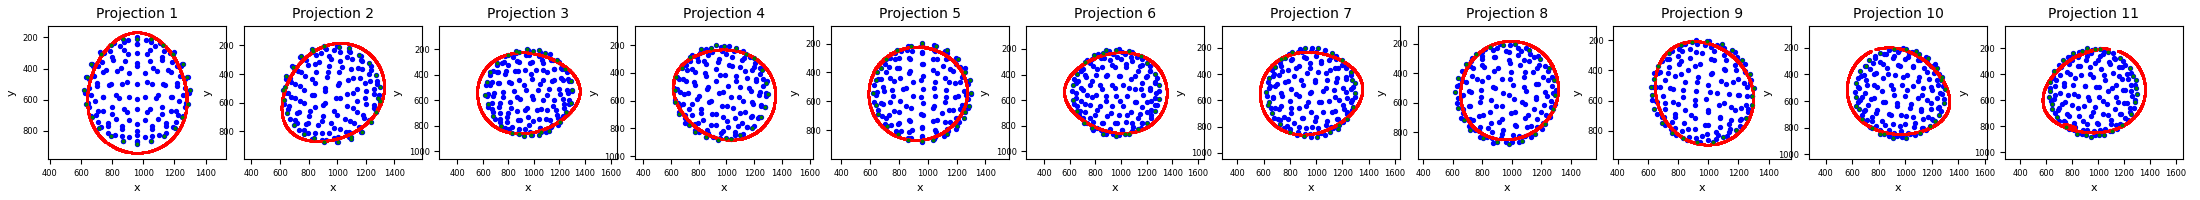

   0 Loss: 26057.549 Volume: 4.249
GT Chamfer: [0.034] GT IoU: [0.801]
   1 Loss: 24860.996 Volume: 4.249
GT Chamfer: [0.033] GT IoU: [0.805]
   2 Loss: 22524.631 Volume: 4.249
GT Chamfer: [0.031] GT IoU: [0.814]
   3 Loss: 19772.460 Volume: 4.249
GT Chamfer: [0.030] GT IoU: [0.825]
   4 Loss: 16998.665 Volume: 4.249
GT Chamfer: [0.028] GT IoU: [0.838]
   5 Loss: 15125.083 Volume: 4.249
GT Chamfer: [0.027] GT IoU: [0.852]
unioned.geom_type == 'MultiPolygon'
   6 Loss: 13317.816 Volume: 4.249
GT Chamfer: [0.025] GT IoU: [0.866]
   7 Loss: 11815.908 Volume: 4.249
GT Chamfer: [0.024] GT IoU: [0.880]
   8 Loss: 10970.002 Volume: 4.249
GT Chamfer: [0.023] GT IoU: [0.893]
   9 Loss: 10528.800 Volume: 4.249
GT Chamfer: [0.023] GT IoU: [0.904]
  10 Loss: 10353.553 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.914]
  11 Loss: 9897.083 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.922]
  12 Loss: 9328.084 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.930]
unioned.geom_type == 'MultiPolygon'
  13 Lo

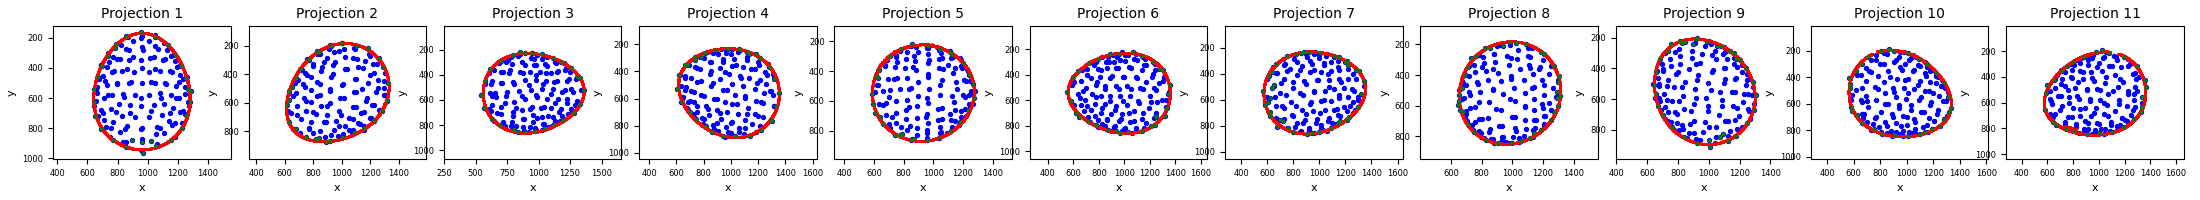

  20 Loss: 8451.387 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.954]
  21 Loss: 8419.213 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.955]
  22 Loss: 8337.236 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.955]
  23 Loss: 8317.717 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.956]
unioned.geom_type == 'MultiPolygon'
  24 Loss: 8010.395 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.957]
  25 Loss: 7836.205 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.957]
  26 Loss: 7760.937 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.958]
  27 Loss: 7714.895 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.958]
  28 Loss: 7753.217 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.958]
  29 Loss: 7757.845 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.958]
  30 Loss: 7699.658 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.957]
  31 Loss: 7671.230 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.957]
  32 Loss: 7704.501 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.957]
  33 Loss: 7654.128 Volume: 4.249
GT Chamfer: [0.020] 

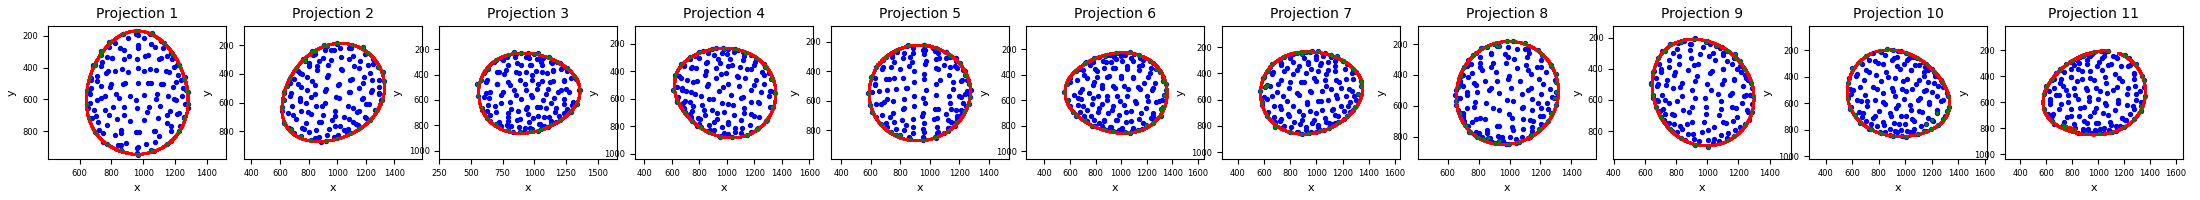

  40 Loss: 7543.392 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.954]
  41 Loss: 7532.900 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.954]
  42 Loss: 7526.108 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.953]
  43 Loss: 7474.807 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.953]
  44 Loss: 7406.703 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.953]
  45 Loss: 7362.668 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.953]
  46 Loss: 7318.580 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.953]
  47 Loss: 7249.073 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.952]
  48 Loss: 7483.922 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.952]
  49 Loss: 7463.321 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.952]
  50 Loss: 7390.434 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.952]
  51 Loss: 7368.813 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.952]
  52 Loss: 7171.433 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.952]
  53 Loss: 7088.849 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.951]
  54 Loss: 7112.632 

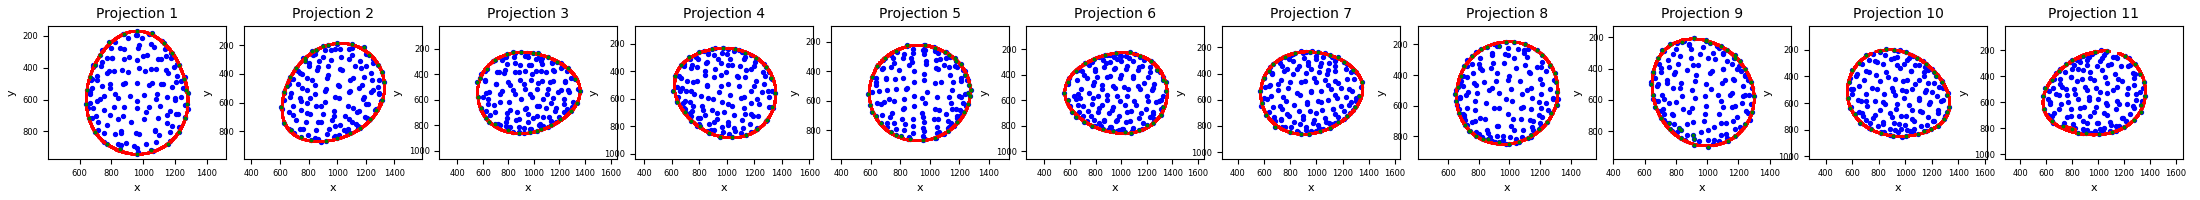

  60 Loss: 7011.954 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.950]
  61 Loss: 6923.493 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.950]
  62 Loss: 6904.948 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.950]
  63 Loss: 6934.759 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.950]
  64 Loss: 6844.580 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.950]
  65 Loss: 6736.817 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.950]
  66 Loss: 6709.123 Volume: 4.249
GT Chamfer: [0.020] GT IoU: [0.950]
  67 Loss: 6759.732 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.950]
  68 Loss: 6763.124 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.949]
  69 Loss: 6726.323 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.949]
  70 Loss: 6716.620 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.949]
  71 Loss: 6661.845 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.949]
  72 Loss: 6663.056 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.949]
  73 Loss: 6890.161 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.949]
  74 Loss: 6890.735 

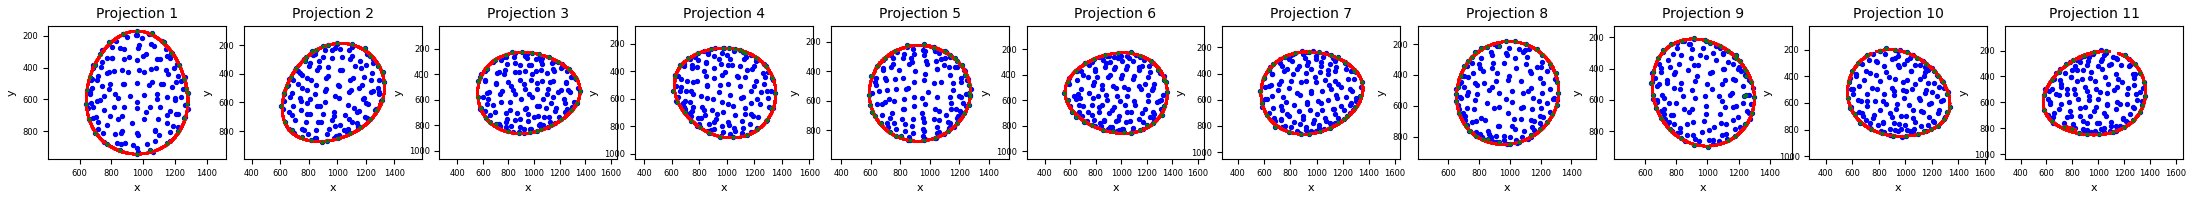

  80 Loss: 6852.639 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  81 Loss: 6672.910 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  82 Loss: 6661.383 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  83 Loss: 6734.894 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  84 Loss: 6679.138 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  85 Loss: 6636.145 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  86 Loss: 6601.483 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  87 Loss: 6590.699 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  88 Loss: 6583.755 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  89 Loss: 6543.036 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  90 Loss: 6539.757 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  91 Loss: 6795.421 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  92 Loss: 7000.307 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  93 Loss: 6967.726 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.948]
  94 Loss: 6979.716 

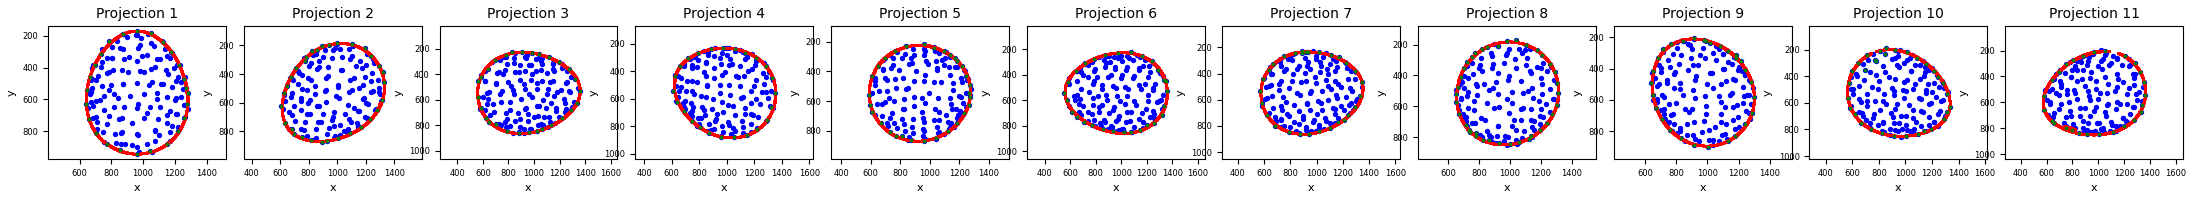

In [12]:
final_verts = outer_problem(sphere, balloon, projmats, batch_tgt_edgemap_info, n_iters=100, lr=1e-6,moment=0.8)

In [15]:
visualise_meshes(Meshes(verts=final_verts.detach(),faces=sphere.faces_packed().unsqueeze(0)), balloon)


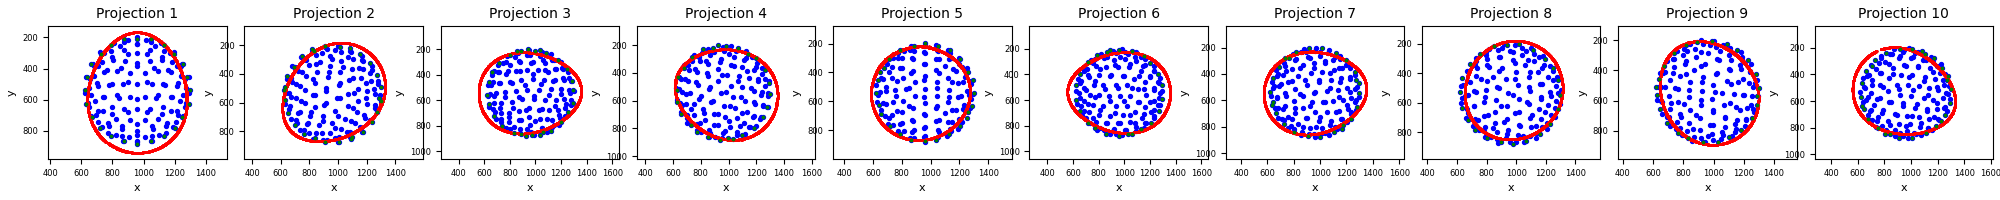

   0 Loss: 25189.446 Volume: 4.249
GT Chamfer: [0.034] GT IoU: [0.801]
   1 Loss: 23920.312 Volume: 4.249
GT Chamfer: [0.033] GT IoU: [0.805]
   2 Loss: 21791.794 Volume: 4.249
GT Chamfer: [0.032] GT IoU: [0.813]
   3 Loss: 19309.994 Volume: 4.249
GT Chamfer: [0.030] GT IoU: [0.824]
   4 Loss: 17106.780 Volume: 4.249
GT Chamfer: [0.029] GT IoU: [0.836]
   5 Loss: 15036.290 Volume: 4.249
GT Chamfer: [0.027] GT IoU: [0.849]
   6 Loss: 12893.718 Volume: 4.249
GT Chamfer: [0.026] GT IoU: [0.862]
   7 Loss: 11457.562 Volume: 4.249
GT Chamfer: [0.025] GT IoU: [0.875]
   8 Loss: 10941.022 Volume: 4.249
GT Chamfer: [0.024] GT IoU: [0.887]
   9 Loss: 11078.030 Volume: 4.249
GT Chamfer: [0.024] GT IoU: [0.897]
  10 Loss: 10584.608 Volume: 4.249
GT Chamfer: [0.023] GT IoU: [0.905]
  11 Loss: 9979.510 Volume: 4.249
GT Chamfer: [0.023] GT IoU: [0.913]
  12 Loss: 9537.090 Volume: 4.249
GT Chamfer: [0.023] GT IoU: [0.919]
unioned.geom_type == 'MultiPolygon'
  13 Loss: 8929.528 Volume: 4.249
GT Chamfe

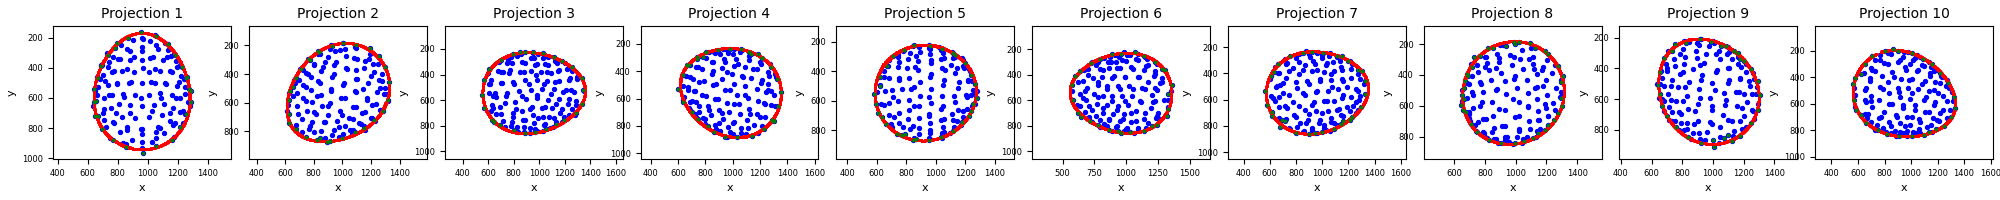

  20 Loss: 7582.169 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.941]
  21 Loss: 7502.715 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.942]
  22 Loss: 7590.055 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.942]
  23 Loss: 7604.011 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.942]
  24 Loss: 7568.635 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.943]
  25 Loss: 7768.430 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.943]
  26 Loss: 8095.581 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.943]
  27 Loss: 8055.590 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.943]
  28 Loss: 8066.763 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.943]
  29 Loss: 8043.338 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.943]
  30 Loss: 7918.568 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.943]
  31 Loss: 7740.861 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.943]
  32 Loss: 7749.108 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.943]
  33 Loss: 7697.684 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.942]
unioned.geom_type ==

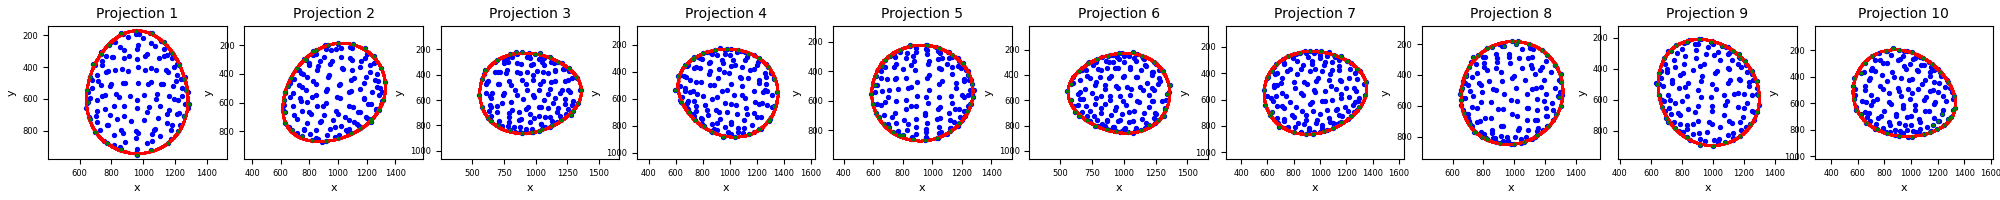

  40 Loss: 7352.616 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.942]
  41 Loss: 7308.612 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  42 Loss: 7280.774 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  43 Loss: 7238.096 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  44 Loss: 7207.657 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  45 Loss: 7002.621 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  46 Loss: 6989.468 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  47 Loss: 6974.961 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  48 Loss: 6932.966 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  49 Loss: 6857.066 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  50 Loss: 6864.154 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  51 Loss: 6852.620 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  52 Loss: 6902.147 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  53 Loss: 6851.555 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.941]
  54 Loss: 7018.242 

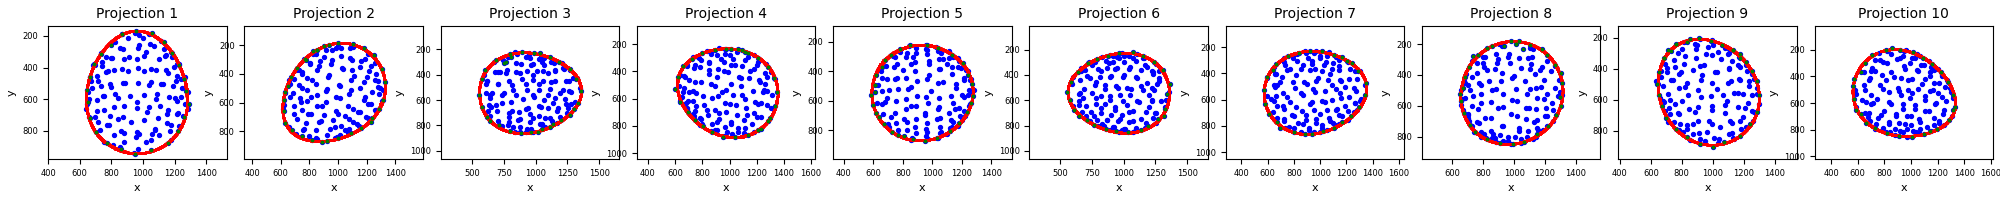

  60 Loss: 6964.308 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.940]
unioned.geom_type == 'MultiPolygon'
  61 Loss: 6935.483 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.940]
unioned.geom_type == 'MultiPolygon'
  62 Loss: 6969.412 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.940]
unioned.geom_type == 'MultiPolygon'
  63 Loss: 6917.596 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.940]
unioned.geom_type == 'MultiPolygon'
  64 Loss: 6892.009 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.940]
  65 Loss: 6885.175 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.940]
  66 Loss: 6805.267 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.939]
  67 Loss: 6816.456 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.939]
  68 Loss: 6795.509 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.939]
  69 Loss: 6798.586 Volume: 4.249
GT Chamfer: [0.021] GT IoU: [0.939]
  70 Loss: 6821.655 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.939]
  71 Loss: 6737.889 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.939]
  72 Loss: 6671.

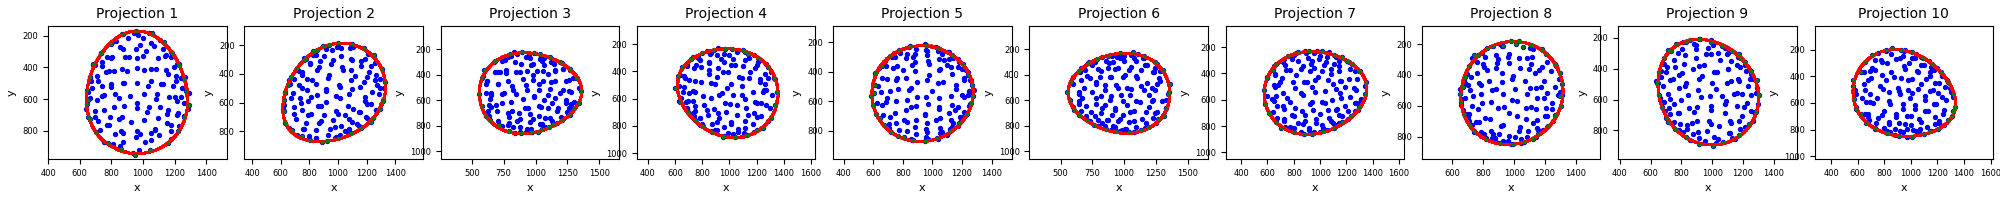

  80 Loss: 6633.732 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.938]
  81 Loss: 6682.943 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.938]
  82 Loss: 6699.138 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.938]
  83 Loss: 6643.728 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.938]
  84 Loss: 6615.131 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.938]
  85 Loss: 6546.298 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.938]
  86 Loss: 6616.042 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.938]
  87 Loss: 6594.249 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.938]
  88 Loss: 6540.965 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.938]
  89 Loss: 6649.266 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.937]
  90 Loss: 6467.357 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.937]
  91 Loss: 6445.822 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.937]
  92 Loss: 6429.098 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.937]
  93 Loss: 6520.099 Volume: 4.249
GT Chamfer: [0.022] GT IoU: [0.937]
  94 Loss: 6509.192 

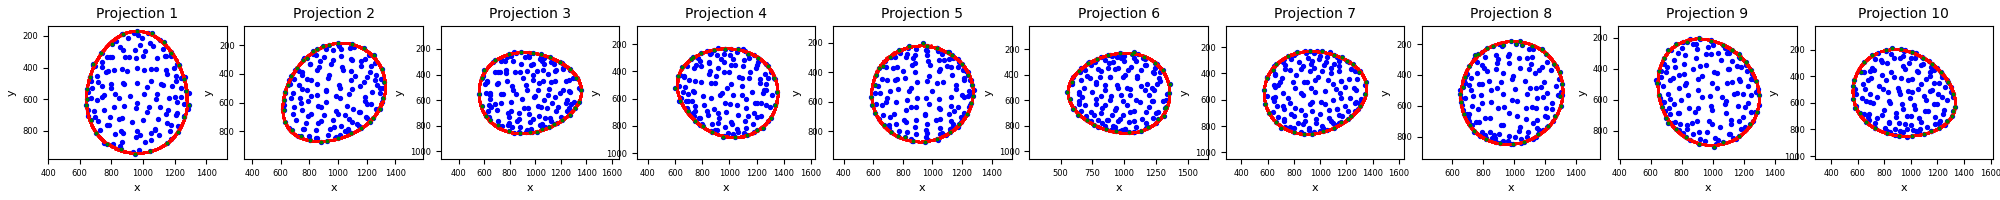

In [17]:
view_idx = [0,1,2,3,5,6,7,8,9,10]
tgt = "balloon"
options=[
    (True, 80, 700), #0
    (False, 5, 120),
    (False, 10, 180),
    (True, 40, 600),
    (True, 40, 600),
    (False, 0, 180), # bad
    (True, 200, 900),
    (False, 10, 200),
    (False, 10, 200),
    (False, 20, 250),
    (False, 0, 300),
    (True, 200, 900), # meh
]
edgemaps, edgemaps_len = get_edgemaps(renders,tgt,options)
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])
final_verts = outer_problem(sphere, balloon, projmats, batch_tgt_edgemap_info, n_iters=100, lr=1e-6,moment=0.8)

In [18]:
visualise_meshes(Meshes(verts=final_verts.detach(),faces=sphere.faces_packed().unsqueeze(0)), balloon)


In [ ]:
view_idx = [0,1,2,3,5,6,7,8,11]
# view_idx = list(range(12))
tgt = "rstrawberry"
options = [
    (True, 40, 400),
    (False, 5, 250),
    (False, 10, 200),
    (True, 100, 400), # 3, bad
    (False, 5, 200), # 4, meh
    (False, 10, 200),
    (False, 15, 220),
    (False, 15, 250),
    (False, 15, 200),
    (True, 150, 500), # 9, bad
    (False, 0, 320),
    (False, 0, 250)
]
edgemaps, edgemaps_len = get_edgemaps(renders, options)
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])


plot_projections(balloon.verts_packed().double(), projmats, tgt_edgemap_info)

In [14]:
def visualise_meshes(srcmesh, tgtmesh):
    vertices = np.asarray(srcmesh.verts_packed())
    faces = np.asarray(srcmesh.faces_packed())

# Create a Plotly 3D mesh
    fig = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=1,
        color="lightblue"
    )])

    vertices = np.asarray(tgtmesh.verts_packed())
    faces = np.asarray(tgtmesh.faces_packed())

    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=0.1,
        color="red"
    ))

    # Update layout for better presentation
    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X"),
            yaxis=dict(title="Y"),
            zaxis=dict(title="Z"),
        ),
        title="3D Mesh Visualization"
    )

    # Show the figure
    fig.show()


In [ ]:
renders_path = "../data/sky/renders"
renders = load_renders(renders_path)
matrices_path = "../data/sky/cameras"
matrices = load_camera_matrices(matrices_path)

options=[[
    (True, 50, 200), #0
    (False, 5, 120),
    (False, 10, 180),
    (True, 40, 600),
    (True, 40, 600),
    (False, 0, 180), # bad
    (True, 200, 900),
    (False, 10, 200),
    (False, 10, 200),
    (False, 20, 250),
    (False, 0, 300),
    (True, 100, 900), # meh
], [
    (True, 40, 400),
    (False, 5, 250),
    (False, 10, 200),
    (True, 100, 400), # 3, bad
    (False, 5, 200), # 4, meh
    (False, 10, 200),
    (False, 15, 220),
    (False, 15, 250),
    (False, 15, 200),
    (True, 150, 500), # 9, bad
    (False, 0, 320),
    (False, 0, 250)
]]

views = [[0,1,2,3,5,6,7,8,9,10,11],
         [0,1,2,3,5,6,7,8,11] 
         ]


def pipeline(src, tgts, tgt_names, views, options):
    T = len(tgts)
    print(T)
    src_mesh = src
    renders_path = "../data/sky/renders"
    renders = load_renders(renders_path)
    matrices_path = "../data/sky/cameras"
    matrices = load_camera_matrices(matrices_path)
    for t in range(T):
        view_idx = views[t]
        tgt_mesh = tgts[t]
        edgemaps, edgemaps_len = get_edgemaps(renders, options[t])
        projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt_names[t], matrices, edgemaps, edgemaps_len)
        batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])
        final_verts = outer_problem(src_mesh, tgt_mesh, projmats, batch_tgt_edgemap_info, n_iters=20, lr=5e-6,moment=0.5)
        src_mesh = Meshes(verts=final_verts, faces=tgt_mesh.faces_padded())
        visualise_meshes(src_mesh, tgt_mesh)

In [ ]:
tgts = join_meshes_as_batch([balloon, rstrawberry,parabola])
tgt_names = ["balloon", "rstrawberry","parabola"]
pipeline(sphere, tgts, tgt_names, views, options)